# Задачи курса
1. Считать аудио файл (можно использовать библиотечные функции)
2. Научится добавлять писк (правильно подобранная синусойда) к аудио данным и записывать файл обратно.
3. Посчитать спектрограмму (нужно реализовать самостоятельно)
4. Показать влияние синусойды
5. Реализовать фильтр Чебышёва (во временной шкале) для того чтобы убрать писк
6. Показать какое влияние оказывает на спектрограмму.
7. Выделить гармоники, хотя бы главную.
8. Построить её график.
9. Реализовать корректное ускорение/замедление проигрывания не искажающее частоту.

Фактически все нужно реализовать вручную. Пункты можно объединять если это удобно в одну программу.
Язык любой. Файл лучше поищите сами. Формат наверное wav.
Ограничения. Время работы должно быть не больше десятка секунд на каждый из рассматриваемых пунктов при показе. т.е. эффективность с точки зрения теории алгоритмов не учитывается

### Источники информации
https://vk.com/doc-132177380_490658870?hash=32f012da237dd9993d&dl=2af63196e312a1dd15  
http://www.mai-trt.ru/docs/edu/lek_or_ruch_06.pdf  
http://www.mai-trt.ru/docs/edu/lek_or_ruch_07.pdf  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display as ipd  # для воспроизведения аудио-файла
from librosa import display         # для визуализации

import ReadWriteNoise  as RWN       # задачи 1-2
import Spectrogram     as Sp        # задача 3 (+ задачи 4,6)
import ChebyshevFilter as ChF       # задача 5

Для иллюстрации полученных результатов будем использовать следующие функции.

In [2]:
# для визуализации в блокноте
def waveplot(x, sr):
    plt.style.use('ggplot')
    plt.figure(figsize=(14, 5))
    display.waveplot(x, sr=sr)

Аудио-файлы:

In [3]:
wavName = 'AudioFiles/guitar.wav'
#wavName = 'AudioFiles/celtic.wav'
#wavName = 'AudioFiles/pchela.wav'
#wavName = 'AudioFiles/nizkochastotnyj_zvuk.wav'
#wavName = 'AudioFiles/wicked_game.wav'

# Задача 1. Считывание файла

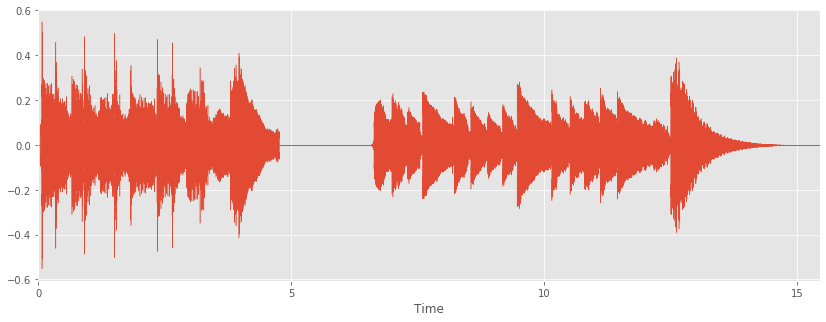

In [4]:
x, sr = RWN.read_audio(wavName)

waveplot(x, sr)
ipd.Audio(x, rate=sr)

# Задача 2. Добавление писка

В качестве писка выбран звук с частотой (по умолчанию) 15 кГц (примерный диапозон частот звука, слышимых человеком 16 Гц - 20 кГц)

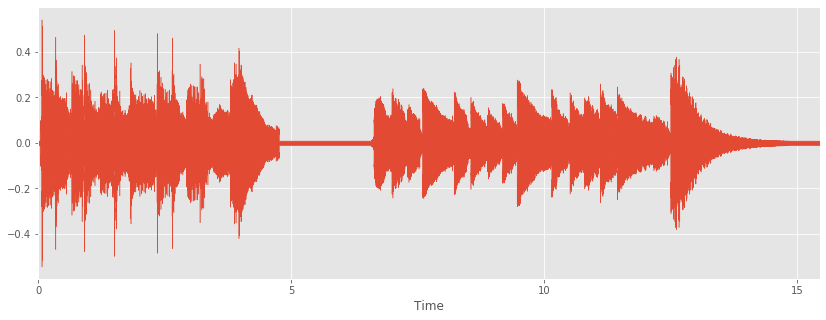

In [5]:
x_noise = RWN.add_noise(x, sr) #f_noise = 15000

waveplot(x_noise, sr)
ipd.Audio(x_noise, rate=sr)

In [25]:
RWN.write_audio(wavName[:-4] + "_noise.wav", x,sr)

written to 'AudioFiles/guitar_noise.wav'


# Задача 3. Спектрограмма

**Спектрограмма** — это визуальный способ представления уровня или “громкости” сигнала во времени на различных частотах, присутствующих в форме волны.  
На вертикальной оси показаны частоты (от 0 до 22 кГц), а на горизонтальной — время. Третье измерение с указанием амплитуды на определенной частоте в конкретный момент времени представлено интенсивностью или цветом каждой точки изображения.

In [6]:
wind_n = 1000

sound time series length: 340703
spectrogram shape: (1000, 340)


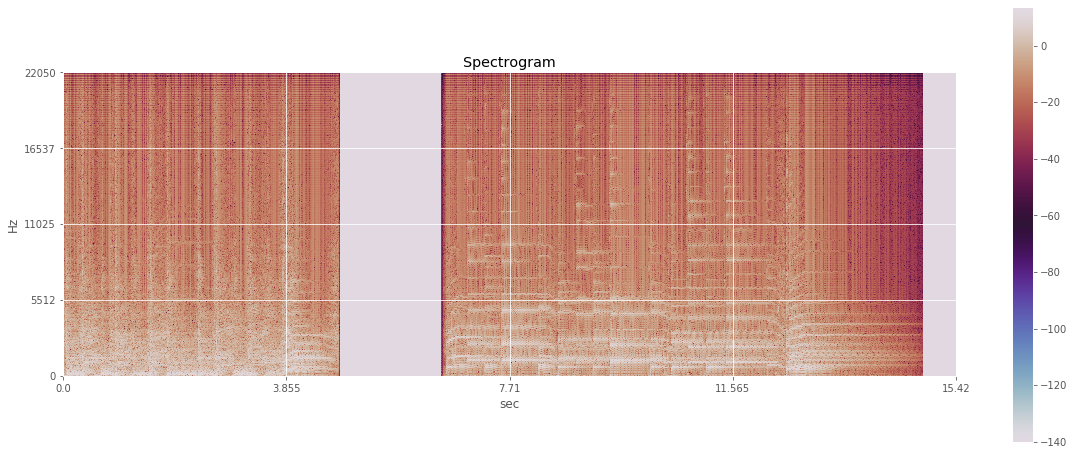

In [7]:
spect, wind_l = Sp.make_spectrogram(x,wind_n)
Sp.plot_spectrogramm (spect.T, sr, wind_l, len(x), wind_n)

Для примера и для общего развития покажем, как работает библиотечная функция `librosa.display.specshow`

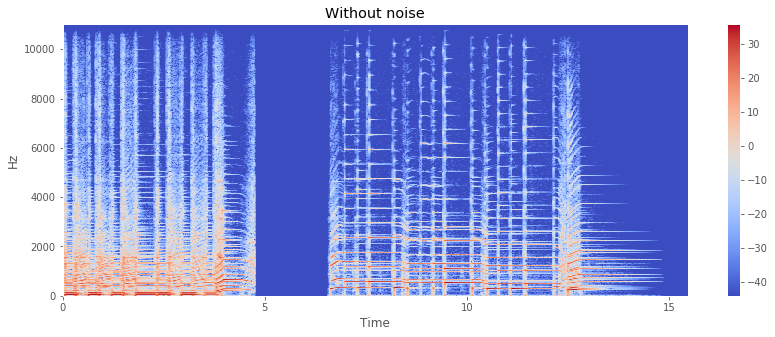

In [17]:
# библиотечная функция
from librosa import stft,  amplitude_to_db
from librosa.display import specshow

X = stft(x)
Xdb = amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
plt.title("Without noise")
specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

# Задача 4. Спектрограмма. Влияние писка.

sound time series length: 340703
spectrogram shape: (1000, 340)


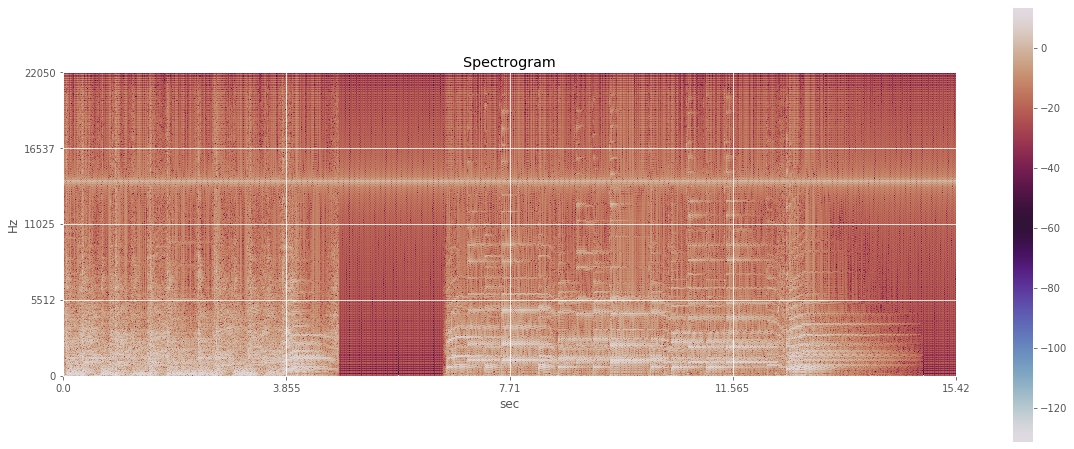

In [8]:
spect_noise, wind_l = Sp.make_spectrogram(x_noise,wind_n)
Sp.plot_spectrogramm (spect_noise.T, sr, wind_l, len(x), wind_n)

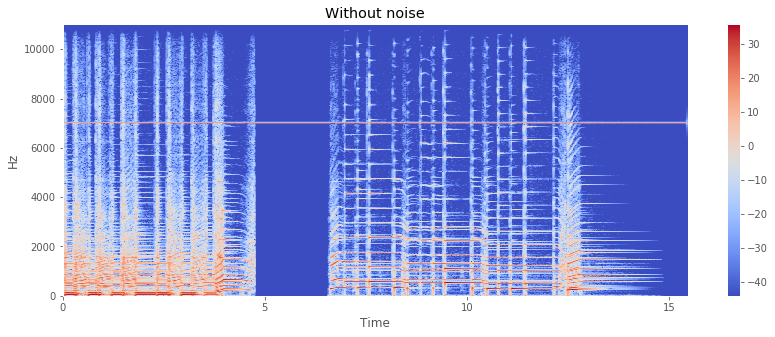

In [10]:
# библиотечная функция
from librosa import stft,  amplitude_to_db
from librosa.display import specshow

X = stft(x_noise)
Xdb = amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
plt.title("Without noise")
specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

# Задача 5. Фильтр Чебышева

Для начала рассмотрим понятие коэффициента передачи. Входной и выходной сигнал можно представить в виде интеграла Фурье и определить коэффициент передачи цепи $K(\omega)$ как

$$K(\omega) = \frac{U_{\text{вых}}(\omega) }{U_{\text{вх}}(\omega) } = |K(\omega)|e^{i arg(K(\omega))}$$

Введем нормированную частоту $\Omega = \frac{\omega}{\omega_0}$, где $\omega_0$ - граничная частота полосы пропускания (полосы, в которой выделяется сигнал).   
Обобщенная формула амплитудно-частотной характеристики для фильтра низких частот:

$$K(\Omega) = \frac{1}{\sqrt{1 + \varepsilon^2 F(\Omega)}}$$

Здесь $F(\Omega)$ - фунция фильтрации, она определяется типом фильтра. Для любой функции фильтрации стправедливо $F(1) = 1$

В **фильтрах Чебышева** в качестве функции фильтрации  используется квадрат полинома Чебышева 

$$F(\Omega) = T_n^2(\Omega)$$

Многочлены Чебышёва первого рода $T_n(x)$ могут быть определены с помощью рекуррентного соотношения:

$$T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x),\quad T_0(x) = 1\ ,\ T_1(x) = x $$
Примеры полиномов Чебышева:  
$\begin{array}
& T_0(x) = & 1\ ;               & T_1(x) = & x \\
  T_2(x) = & 2x^2 - 1\ ;        & T_3(x) = & 4x^3 - 3x\\
  T_4(x) = & 8x^4 - 8x^2 + 1\ ; & T_5(x) = & 16x^5 - 20x^3 + 5x
\end{array}$ 



Для реализации фильтра Чебышева **для конкретной задачи** были выбраны специальные значения  $\omega_0,\ \varepsilon$ и степени полинома Чебышева, а именно:
$$\omega_0 = 10000$$
$$\varepsilon = 0.07$$
$$F(\Omega) = T_20^2(\Omega)$$

In [29]:
# граничная частота
w0 = 13000
# параметр коэффициента передачи
eps = 0.07
# степень полинома Чебышева
deg = 20

  
Ниже представлен график $K(x)$ для выбранных параметров. Коротко и своими словаи его можно описать следующим образом. Поведение графика при $x < 1$ соответтвует деформации сигнала, который мы считаем "эталонным": чем больше отклонение графика от единицы - тем больше деформация. Поведение графика при $x > 1$ соответвует качеству фильтрации "плохого" сигала: чем ближе график к прямой $x = 1$, тем лучше фильтрация.  
Точка перечесечения графика $K(x)$ и прямой, соответвующей писку, показывает во сколько раз уменьшится его частота.  


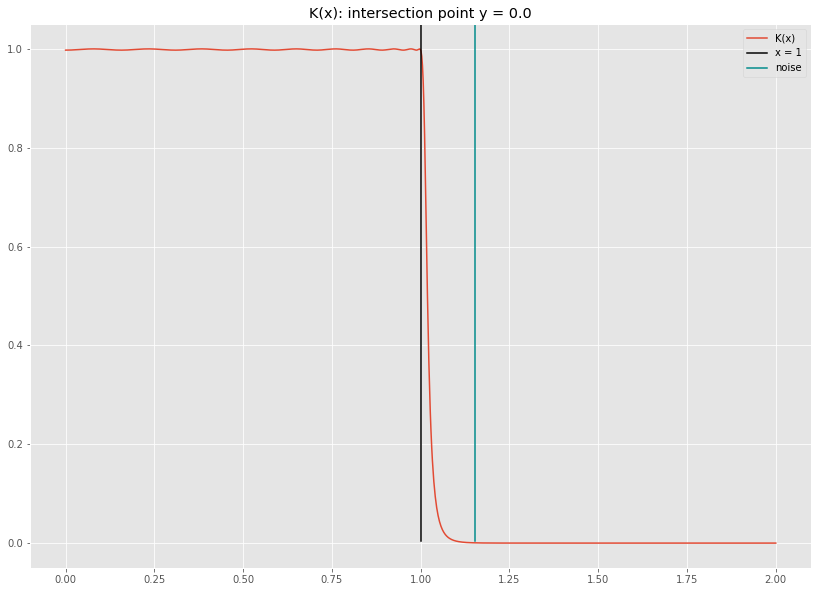

In [30]:
def K(x):
    return 1/np.sqrt(1 + eps**2 * ChF.cheb_function(deg, x)**2)

grid = np.linspace(0, 2, 1000)
plt.style.use('ggplot')
plt.figure(figsize=(14, 10))
plt.title("K(x): intersection point y = {}".format(round( K(1.5), 4 )))
plt.plot(grid, [K(x) for x in grid], label = "K(x)" )                           # K(x)
plt.axvline(x=1,   ymin=0.05, ymax=1.0, color = 'black',    label = "x = 1")    # x = 1
plt.axvline(x=15000/w0, ymin=0.05, ymax=1.0, color = 'darkcyan', label = "noise")    # x = 1.5 (частота писка)
plt.legend()

А вот и сам фильтр Чебышева

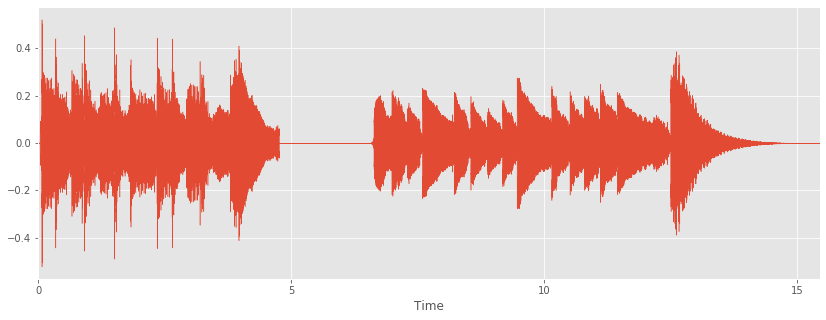

In [31]:
x_noise_filter = ChF.chebyshev_noise_filter(x_noise, w0, sr, deg, eps)

waveplot(x_noise_filter, sr)
ipd.Audio(x_noise_filter, rate=sr)

# Задача 6. Фильтр Чебышева. Спектрограмма

sound time series length: 340703
spectrogram shape: (1000, 340)


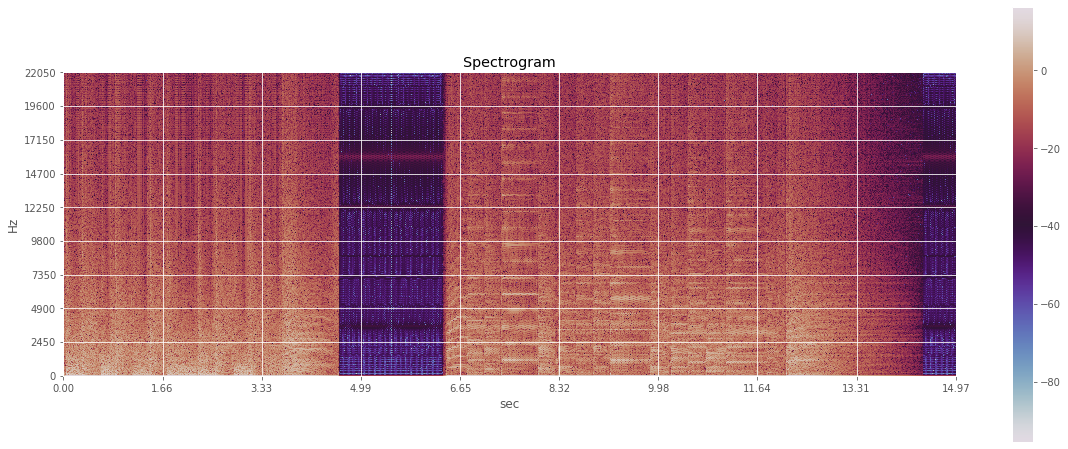

In [32]:
spect_noise_filter, wind_l = Sp.make_spectrogram(x_noise_filter,wind_n)
spect_noise_filter = Sp.norm_log(spect_noise_filter)
Sp.plot_spectrogramm (spect_noise_filter.T, sr, wind_l, len(x), wind_n)

# Задача 7. Выделение гармоник.